# Human Activity Recognition – Assignment 1  
### 5ARE0, Academic Year 2025–2026  

**Group 13**  

**Contributors:**  
- Stan Lamerikx
- Simon Lammertink
- Philip Offermans

---

## Import Modules

In [2]:
import zipfile
import os
import pandas as pd
from pathlib import Path
import glob
import numpy as np
import matplotlib.pyplot as plt
import math
from typing import Iterable, Dict, List, Optional, Tuple, Union

## Load Data

In [3]:
# Folder where your zip files are stored
zip_folder = "./data"

data_dirs = []
# Loop through all files in the folder
for file in os.listdir(zip_folder):
    if file.endswith(".zip"):
        zip_path = os.path.join(zip_folder, file)
        extract_dir = os.path.splitext(zip_path)[0]  # remove .zip
        
        # Add folder to list of folders with data
        data_dirs.append(extract_dir)

        # Create the directory if it doesn't exist
        os.makedirs(extract_dir, exist_ok=True)

        # Extract contents
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)

        print(f"Extracted {zip_path} to {extract_dir}")


Extracted ./data/running_2.zip to ./data/running_2
Extracted ./data/walking_2.zip to ./data/walking_2
Extracted ./data/sittingDown+StandingUp_2.zip to ./data/sittingDown+StandingUp_2
Extracted ./data/climbingStairs_1.zip to ./data/climbingStairs_1
Extracted ./data/running_1.zip to ./data/running_1
Extracted ./data/climbingStairs_3.zip to ./data/climbingStairs_3
Extracted ./data/climbingStairs_2.zip to ./data/climbingStairs_2
Extracted ./data/sittingDown+StandingUp_1.zip to ./data/sittingDown+StandingUp_1
Extracted ./data/walking_3.zip to ./data/walking_3
Extracted ./data/sittingDown+StandingUp_3.zip to ./data/sittingDown+StandingUp_3
Extracted ./data/running_3.zip to ./data/running_3
Extracted ./data/walking_1.zip to ./data/walking_1


## Data Exploration

In [4]:
# Loop over all CSV files in the directory
data_dir = data_dirs[0]
for file in os.listdir(data_dir):
    if file.endswith(".csv"):
        file_path = os.path.join(data_dir, file)  # ✅ include directory
        print(f"\n--- {file} ---")
        try:
            df = pd.read_csv(file_path)  # ✅ use full path here
            print(df.head())
        except Exception as e:
            print(f"Could not read {file}: {e}")



--- AccelerometerUncalibrated.csv ---
                  time  seconds_elapsed          z         y         x
0  1757419446965810000         0.134810   8.489435  3.952644 -3.138785
1  1757419446984727800         0.153728  10.076775  6.583851 -2.961417
2  1757419447003645700         0.172646   8.087142  2.978167 -1.206581
3  1757419447022563600         0.191563   7.416853  3.358925 -4.689932
4  1757419447041481500         0.210481   6.160023  3.222534 -4.843372

--- Accelerometer.csv ---
                  time  seconds_elapsed         z         y         x
0  1757419446972768800         0.141769 -1.171882  0.344530 -0.361200
1  1757419446991686700         0.160687  0.236252  2.092710 -0.013197
2  1757419447010604500         0.179604 -1.361830 -1.427356  1.303086
3  1757419447029522400         0.198522 -1.586996 -0.713547 -2.047243
4  1757419447048440300         0.217440 -2.397018 -0.740455 -1.748519

--- Annotation.csv ---
Could not read Annotation.csv: No columns to parse from file

--

- Annotation.csv, Metadata.csv don't contain information that is usefull for the project
- The csv with Uncalibrated data likely have the same information as the calibrated version, but this is something that needs more investigation
- The csv that contain data have a time entry that can show the exact time the data was logged. For this project this is not needed

## Create Samples

In [5]:
SENSORS: list[str] = [
    "AccelerometerUncalibrated",
    "Accelerometer",
    "TotalAcceleration",
    "Gyroscope",
    "GyroscopeUncalibrated",
    "Gravity",
]

ACTIONS: list[str] = [
    "climbingStairs",
    "running",
    "sittingDown+StandingUp",
    "walking",
]


def _csv_to_matrix(csv_path: Path) -> pd.DataFrame:
    """
    Read CSV -> drop 'time' if present -> return as DataFrame.
    Keeps all other columns.
    """
    df = pd.read_csv(csv_path)
    if "time" in df.columns:
        df = df.drop(columns=["time"])
    return df


def _split_into_samples(df: pd.DataFrame, sample_size: float) -> list[pd.DataFrame]:
    """
    Split df into 5s windows, then from each 5s window take a centered sub-window
    of length `sample_size` seconds (sample_size must be <= 5). For each sample,
    reset seconds_elapsed to start at 0.

    Examples:
      sample_size=5 -> take [0,5) of each 5-second window
      sample_size=3 -> take [1,4) of each 5-second window
    """
    if "seconds_elapsed" not in df.columns:
        raise KeyError("Column 'seconds_elapsed' is required.")
    if sample_size <= 0:
        raise ValueError("sample_size must be > 0.")
    if sample_size > 5:
        raise ValueError("sample_size must be <= 5.")

    samples: list[pd.DataFrame] = []
    t = df["seconds_elapsed"].astype(float)
    min_t, max_t = t.min(), t.max()

    # iterate in 5-second bins
    start_base = int(math.floor(min_t))
    end_base = int(math.ceil(max_t))
    window_size = 5.0

    # centered offsets inside each 5s window
    start_off = (window_size - sample_size) / 2.0
    end_off = start_off + sample_size  # half-open [start_off, end_off)

    for start in range(start_base, end_base, 5):
        w_start = float(start)
        w_end = w_start + window_size

        # grab the 5-second chunk
        in_window = (t >= w_start) & (t < w_end)
        chunk5 = df.loc[in_window]
        if chunk5.empty:
            continue

        # relative time within the 5s window (start at the first timestamp in this window)
        chunk5 = chunk5.copy()
        rel0 = chunk5["seconds_elapsed"].iloc[0]
        chunk5["__rel"] = chunk5["seconds_elapsed"] - rel0

        # take the centered sub-window [start_off, end_off)
        mask = (chunk5["__rel"] >= start_off) & (chunk5["__rel"] < end_off)
        sub = chunk5.loc[mask].drop(columns="__rel")
        if sub.empty:
            continue

        # reset seconds_elapsed to start at 0 for this sample
        sub = sub.reset_index(drop=True).copy()
        sub["seconds_elapsed"] = sub["seconds_elapsed"] - sub["seconds_elapsed"].iloc[0]
        samples.append(sub)

    return samples


def clean_action(sample_size: int, recordings: list[str], SENSORS: list[str]) -> dict:
    """
    Clean all recordings for one action.
    Cuts each recording between 20 and 320 seconds,
    splits into <sample_size> chunks,
    resets seconds_elapsed to start at 0,
    returns {sensor: [df1, df2, ...]}.
    """
    out = {sensor: [] for sensor in SENSORS}
    for recording in recordings:
        for sensor in SENSORS:
            csv_path = Path(recording) / f"{sensor}.csv"
            df = _csv_to_matrix(csv_path)

            # Apply cut
            df_cut = df[(df["seconds_elapsed"] >= 20) & (df["seconds_elapsed"] <= 320)].reset_index(drop=True)

            # Split into chunks
            out[sensor].extend(_split_into_samples(df_cut, sample_size))
    return out

def clean_action_sdsu(sample_size: int, recordings: list[str], SENSORS: list[str], action: str) -> dict:
    """

    """
    standingUp_out = {sensor: [] for sensor in SENSORS}
    sittingDown_out = {sensor: [] for sensor in SENSORS}
    for recording in recordings:
        for sensor in SENSORS:
            csv_path = Path(recording) / f"{sensor}.csv"
            df = _csv_to_matrix(csv_path)

            # Apply cut
            df_cut = df[(df["seconds_elapsed"] >= 20) & (df["seconds_elapsed"] <= 620)].reset_index(drop=True)
            samples = _split_into_samples(df_cut, sample_size)
            standingUp_samples = samples[0::2]   # take every 2nd, starting at index 0
            sittingDown_samples = samples[1::2]  # take every 2nd, starting at index 1
            # Split into chunks
            standingUp_out[sensor].extend(standingUp_samples)
            sittingDown_out[sensor].extend(sittingDown_samples)
    return standingUp_out, sittingDown_out

def build_samples(sample_size: int) -> dict:
    final_obj = {}
    for action in ACTIONS:
        recordings = [d for d in glob.glob(f"./data/{action}*/")]
        if action != "sittingDown+StandingUp":
            final_obj[action] = clean_action(sample_size, recordings, SENSORS)
        else:
            samples = clean_action_sdsu(sample_size, recordings, SENSORS, 'sittingDown')
            final_obj['standingUp'] = samples[0]
            final_obj['sittingDown'] = samples[1]
            



    return final_obj


# Build objects for 1s, 3s, 5s
samples_1 = build_samples(1)
samples_3 = build_samples(3)
samples_5 = build_samples(5)

## Function to Visualize Data

In [6]:
def plot_selected_samples(
    samples_sets: Dict[str, Dict[str, Dict[str, List[pd.DataFrame]]]],
    sets: Optional[Iterable[str]] = None,
    actions: Optional[Iterable[str]] = None,
    sensors: Optional[Iterable[str]] = None,
    sample_indices: Optional[Iterable[int]] = None,
    sample_range: Optional[Tuple[int, int]] = None,
    time_col: str = "seconds_elapsed",
    concat_across_samples: bool = True,
    show_grid: bool = True,
    figsize: Tuple[int, int] = (12, 6),
):
    def _get_xyz_columns(df: pd.DataFrame):
        # Prefer named columns if present
        lower = [c.lower() for c in df.columns]
        try:
            x_idx = lower.index("x")
            y_idx = lower.index("y")
            z_idx = lower.index("z")
            return df.columns[x_idx], df.columns[y_idx], df.columns[z_idx]
        except ValueError:
            # Fallback to positional columns 1,2,3
            return df.columns[1], df.columns[2], df.columns[3]

    def _select_sample_ids(n: int) -> List[int]:
        sel = set()
        if sample_range is not None:
            start, end = sample_range
            sel.update(range(max(0, start), min(n, end)))
        if sample_indices is not None:
            sel.update([i for i in sample_indices if 0 <= i < n])
        if not sel:
            # Default to all if nothing was specified
            sel.update(range(n))
        return sorted(sel)

    # Default filters
    sets = list(samples_sets.keys()) if sets is None else list(sets)

    for set_label in sets:
        if set_label not in samples_sets:
            print(f"[skip] Set '{set_label}' not found.")
            continue

        samples_dict = samples_sets[set_label]
        actions_to_use = list(samples_dict.keys()) if actions is None else [a for a in actions if a in samples_dict]

        for action in actions_to_use:
            sensors_map = samples_dict[action]
            sensors_to_use = list(sensors_map.keys()) if sensors is None else [s for s in sensors if s in sensors_map]

            for sensor in sensors_to_use:
                sample_list = sensors_map[sensor]
                ids = _select_sample_ids(len(sample_list))

                # Prepare concatenation or separate plots
                if concat_across_samples:
                    combined = []
                    offset = 0.0
                    for i in ids:
                        df = sample_list[i].copy()
                        if time_col not in df.columns:
                            raise KeyError(f"Time column '{time_col}' not found in DataFrame for {set_label}/{action}/{sensor} sample {i}")
                        # offset time to keep continuous
                        df[time_col] = df[time_col] + offset
                        offset = float(df[time_col].iloc[-1])
                        combined.append(df)

                    if not combined:
                        print(f"[info] No samples selected for {set_label}/{action}/{sensor}.")
                        continue

                    combined_df = pd.concat(combined, ignore_index=True)
                    xcol, ycol, zcol = _get_xyz_columns(combined_df)

                    plt.figure(figsize=figsize)
                    plt.plot(combined_df[time_col], combined_df[xcol], label="x", color="red")
                    plt.plot(combined_df[time_col], combined_df[ycol], label="y", color="green")
                    plt.plot(combined_df[time_col], combined_df[zcol], label="z", color="blue")
                    plt.xlabel("Time elapsed (s)")
                    plt.ylabel(sensor)
                    plt.title(f"{set_label} • {action} • {sensor} • samples {ids[0]}..{ids[-1]}")
                    plt.legend()
                    if show_grid:
                        plt.grid(True)
                    plt.show()
                else:
                    # Plot each sample separately
                    for i in ids:
                        df = sample_list[i].copy()
                        if time_col not in df.columns:
                            raise KeyError(f"Time column '{time_col}' not found in DataFrame for {set_label}/{action}/{sensor} sample {i}")
                        xcol, ycol, zcol = _get_xyz_columns(df)

                        plt.figure(figsize=figsize)
                        plt.plot(df[time_col], df[xcol], label="x", color="red")
                        plt.plot(df[time_col], df[ycol], label="y", color="green")
                        plt.plot(df[time_col], df[zcol], label="z", color="blue")
                        plt.xlabel("Time elapsed (s)")
                        plt.ylabel(sensor)
                        plt.title(f"{set_label} • {action} • {sensor} • sample {i}")
                        plt.legend()
                        if show_grid:
                            plt.grid(True)
                        plt.show()

samples_sets = {
    "1": samples_1,
    "3": samples_3,
    "5": samples_5,
}

## Visualize Data

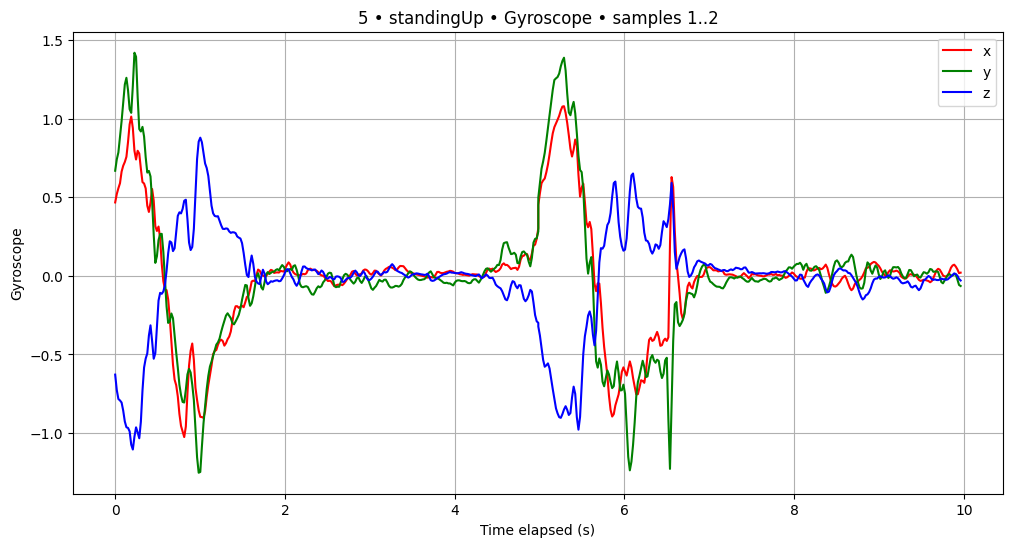

In [7]:
# plot_selected_samples(
#     samples_sets,
#     sets=["1", "3", "5"],
#     actions=["climbingStairs", "walking"],
#     sensors=["Accelerometer", "Gyroscope"],
#     sample_range=(50, 55)
# )

plot_selected_samples(
    samples_sets,
    sets=["5"], # 1, 3, 5
    actions=["standingUp", ], # 'climbingStairs', 'running', 'standingUp', 'sittingDown', 'walking'
    sensors=['Gyroscope'], # 'AccelerometerUncalibrated', 'Accelerometer', 'TotalAcceleration', 'Gyroscope', 'GyroscopeUncalibrated', 'Gravity'
    sample_range=(1, 3) # 0-180
)